In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from google.colab import drive, files
drive.mount('/content/drive')
rootPath = '/content/drive/Shareddrives/KW phase1 repo'

Mounted at /content/drive


In [ ]:
import json
gps = []
with open(rootPath+'/datas/realGPSMeasurements/gpsMeasurement_test.txt', 'r') as f:
  next(f)
  next(f)
  rows = f.readlines()
  for row in rows:
    try:
      _obj = json.loads(row)
      gps.append(_obj)
    except Exception as e:
      pass
print("Total data length: ", len(gps))

Total data length:  72349


In [ ]:
print(gps[0]['GPS'])
print(gps[0]['global_frame'])
print(gps[0]['global_relative_frame'])
print(gps[0]['local_frame'])

{'GPS_eph': 148, 'GPS_epv': 205}
{'lat': 24.9676549, 'lon': 121.1919686, 'alt': 1.2}
{'lat': 24.9676549, 'lon': 121.1919686}
{'lat': 24.9676549, 'lon': 121.1919686, 'alt': 1.2}


In [ ]:
gps_eph = []
gps_epv = []

globalFrame_lat = []
globalFrame_lon = []
globalFrame_alt = []

globalRelativeFrame_lat = []
globalRelativeFrame_lon = []

localFrame_lat = []
localFrame_lon = []
localFrame_alt = []

for iSample in range(len(gps)):
  gps_eph.append(gps[iSample]['GPS']['GPS_eph'])
  gps_epv.append(gps[iSample]['GPS']['GPS_epv'])
  globalFrame_lat.append(gps[iSample]['global_frame']['lat'])
  globalFrame_lon.append(gps[iSample]['global_frame']['lon'])
  globalFrame_alt.append(gps[iSample]['global_frame']['alt'])
  globalRelativeFrame_lat.append(gps[iSample]['global_relative_frame']['lat'])
  globalRelativeFrame_lon.append(gps[iSample]['global_relative_frame']['lon'])
  localFrame_lat.append(gps[iSample]['local_frame']['lat'])
  localFrame_lon.append(gps[iSample]['local_frame']['lon'])
  localFrame_alt.append(gps[iSample]['local_frame']['alt'])

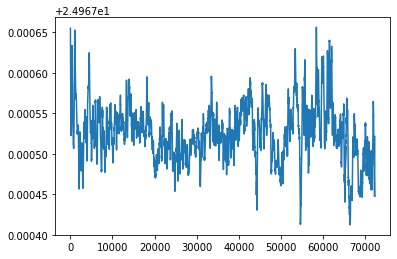

In [ ]:
import matplotlib.pyplot as plt
plt.plot(globalFrame_lat)

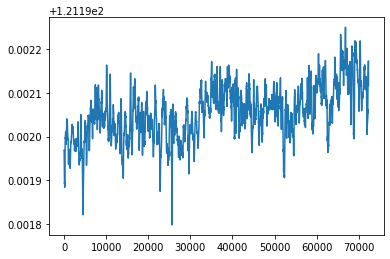

In [ ]:
import matplotlib.pyplot as plt
plt.plot(globalFrame_lon)

In [ ]:
import numpy as np
def calMeanAndDev(data):
  return np.mean(data), np.std(data)

print("global_frame", "lat: mean and dev={}, lon: mean and dev={}, alt: mean and dev={}".format(calMeanAndDev(globalFrame_lat), calMeanAndDev(globalFrame_lon), calMeanAndDev(globalFrame_alt)))

global_frame lat: mean and dev=(24.967525317089386, 3.441916286731533e-05), lon: mean and dev=(121.19205464161911, 6.04686312031896e-05), alt: mean and dev=(137.25804157624844, 12.02327012554791)


In [ ]:
import math
def GeographicCoord2EuclideanDist(lat1, lon1, lat2, lon2):
  R = 6378.137 # Radius of earth in KM
  lat1 = math.radians(lat1)
  lon1 = math.radians(lon1)
  lat2 = math.radians(lat2)
  lon2 = math.radians(lon2)
  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
  distance = R * c
  return distance * 1000; # meters

In [ ]:
def calAnomalyData(lat, lon):
  _mean_lat, _dev_lat = calMeanAndDev(lat)
  _mean_lon, _dev_lon = calMeanAndDev(lon)
  _anomalyData = []
  _normalData = []
  _normal_lat = []
  _normal_lon = []
  _anomaly_lat = []
  _anomaly_lon = []
  for i in range(len(lat)):
    _lat_i = lat[i]
    _lon_i = lon[i]
    _lat_upper = _mean_lat+1.5*_dev_lat
    _lat_lower = _mean_lat-1.5*_dev_lat
    _lon_upper = _mean_lon+1.5*_dev_lon
    _lon_lower = _mean_lon-1.5*_dev_lon
    if (_lat_i > _lat_upper and _lon_i > _lon_upper) or (_lat_i < _lat_lower and _lon_i < _lon_lower) or (_lat_i > _lat_upper and _lon_i < _lon_lower) or (_lat_i < _lat_lower and _lon_i > _lon_upper):
      _d = GeographicCoord2EuclideanDist(_lat_i, _lon_i, _mean_lat, _mean_lon)
      _anomaly_lat.append(_lat_i)
      _anomaly_lon.append(_lon_i)
      _anomalyData.append(_d)
    else:
      _d = GeographicCoord2EuclideanDist(_lat_i, _lon_i, _mean_lat, _mean_lon)
      _normal_lat.append(_lat_i)
      _normal_lon.append(_lon_i)
      _normalData.append(_d)
  
  return _normal_lat,_normal_lon,_anomaly_lat,_anomaly_lon,_normalData, _anomalyData


normalLat,normalLon,anomalyLat,anomalyLon, normalData, anomalyData = calAnomalyData(globalFrame_lat, globalFrame_lon)
print("Normal data mean:  {:.05f} m,\nAnomaly data mean: {:.05f} m".format(np.mean(normalData), np.mean(anomalyData)))
print()
print("Anomaly data min:  {:.05f} m,\nAnomaly data max:  {:.05f} m".format(np.min(anomalyData), np.max(anomalyData)), len(anomalyData))
print()
print("Anomaly data ratio: {:.02f}%".format(len(anomalyData)/(len(normalData)+len(anomalyData))*100))

Normal data mean:  5.67380 m,
Anomaly data mean: 15.42184 m

Anomaly data min:  10.85751 m,
Anomaly data max:  26.68753 m 3145

Anomaly data ratio: 4.35%


In [25]:
with open(rootPath+'/normal_GPS_location.csv', 'w') as f:
  csvWriter = csv.writer(f)
  for i in range(len(normalLat)):
    csvWriter.writerow([normalLat[i], normalLon[i]])

with open(rootPath+'/anomaly_GPS_location.csv', 'w') as f:
  csvWriter = csv.writer(f)
  for i in range(len(anomalyLat)):
    csvWriter.writerow([anomalyLat[i], anomalyLon[i]])

In [ ]:
import csv

with open(rootPath+'/datas/realGPSMeasurements/anomal_gpsDrifting.csv', 'w') as f:
  csvWriter = csv.writer(f)
  for d in anomalyData:
    csvWriter.writerow([d])

with open(rootPath+'/datas/realGPSMeasurements/normal_gpsDrifting.csv', 'w') as f:
  csvWriter = csv.writer(f)
  for d in normalData:
    csvWriter.writerow([d])

In [ ]:
# Install folium package
!pip install folium

In [ ]:
# Making a map using the folium module
import folium
from folium.plugins import HeatMap

In [ ]:
geoData = [globalFrame_lat,globalFrame_lon, np.full(len(globalFrame_lat),1/len(globalFrame_lat))]
geoDataT = np.array(geoData).T
# print(geoDataT[:100])

ref: https://blog.yeshuanova.com/2017/10/python-visulization-folium/

In [ ]:
import numpy as np

avg_normalLat = round(np.mean(normalLat), 6)

a = list(map(lambda x: round(x, 6), normalLat))

print(np.sum([1 for i in a if i == avg_normalLat]))


avg_anomalyLat = round(np.mean(anomalyLat), 4)

a = list(map(lambda x: round(x, 4), anomalyLat))

print(np.sum([1 for i in a if i == avg_anomalyLat]))

1090
1439


In [ ]:
zoom_scale = 19

In [ ]:
import branca.colormap as cm
colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red'], vmin=0, vmax=1000, caption='Normal GPS location measurement number')
colormap

In [ ]:
normalData = [normalLat,normalLon, np.full(len(normalLat), 1/len(normalLat))]
normalDataT = np.array(normalData).T
normal_map = folium.Map(location=[24.967525317089386, 121.19205464161911], tiles='https://{s}.basemaps.cartocdn.com/rastertiles/light_nolabels/{z}/{x}/{y}.png', 
                        attr="KW", zoom_start=zoom_scale, control_scale=True, zoom_control=False, max_zoom=zoom_scale, min_zoom=zoom_scale, width='50%', height='60%')
normal_map.add_child(HeatMap(data=normalDataT[np.random.choice(len(normalDataT), len(anomalyLat))], min_opacity=0.25, blur=5))
normal_map.add_child(colormap)
NCU_COMM_Marker = folium.Marker(location=[24.96745063001892, 121.19163641087044],
                                icon=folium.Icon(color="red", icon="graduation-cap", prefix="fa"))
from folium.features import DivIcon
# NCU_COMM_Text = folium.Marker(location=[24.9674214514102, 121.19162836424401],
#                               icon=DivIcon(
#                                 icon_size=(500,500),
#                                 icon_anchor=(0,0),
#                                 html='<div style="font-size: 20pt">National Central Universary Department of Communication Engineering</div>',
#                                 ))
normal_map.add_child(NCU_COMM_Marker)
# normal_map.add_child(NCU_COMM_Text)
# The last object in the cell always gets shown in the notebook
normal_map

In [ ]:
colormap2 = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red'], vmin=0, vmax=1000, caption='Anomaly GPS location measurement number')
colormap2

In [ ]:
anomalyData = [anomalyLat,anomalyLon, np.full(len(anomalyLat),1/len(anomalyLat))]
anomalyDataT = np.array(anomalyData).T
anomaly_map = folium.Map(location=[24.967525317089386, 121.19205464161911],tiles='https://{s}.basemaps.cartocdn.com/rastertiles/light_nolabels/{z}/{x}/{y}.png',
                         attr="KW",zoom_start=zoom_scale, control_scale=True,zoom_control=False, max_zoom=zoom_scale, min_zoom=zoom_scale, width='50%', height='60%',
                         no_touch=True)
anomaly_map.add_child(HeatMap(data=anomalyDataT,min_opacity=0.25,blur=5))
anomaly_map.add_child(colormap2)
NCU_COMM_Marker = folium.Marker(location=[24.96745063001892, 121.19163641087044],
                                icon=folium.Icon(color="red", icon="graduation-cap", prefix="fa"))
anomaly_map.add_child(NCU_COMM_Marker)
# The last object in the cell always gets shown in the notebook
anomaly_map

In [ ]:
# normal_map.save(rootPath+'/datas/realGPSMeasurements/normal.html')
# anomaly_map.save(rootPath+'/datas/realGPSMeasurements/anomaly.html')

normal_map.save('normal_GPS_drifting.html')
anomaly_map.save('anomaly_GPS_drifting.html')

In [ ]:
from progressbar import *
import sys, time

total = 1000

widgets = ['Progress: ',Percentage(), ' ', Bar('▊'),' ', Timer()]
pbar = ProgressBar(widgets=widgets, maxval=total).start()
for i in range(total):
  pbar.update(i)
  time.sleep(0.005)
pbar.finish()

Progress: 100% |▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊▊| Elapsed Time: 0:00:05
